### This script calculates correlations using Mann-Kendall measure of correlation between observation and models and then plots as heatmap with hatches of Pvalues

### By: Kwesi A. Quagraine (2019)                                                   


In [1]:

#For working with arrays: NumPy
import numpy as np
# For loading netCDF data
from netCDF4 import Dataset
# For calculating linear regression
import scipy.stats
# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 200
plt.rcParams['hatch.linewidth'] = 0.1
# Datetime libraries for converting dates
from datetime import datetime, timedelta 

import xarray as xr
# for creating maps
from mpl_toolkits.basemap import Basemap

# Plots in iPython Notebook, not a pop-up window
%matplotlib inline
#%matplotlib notebook

#high resolution plots
%config InlineBackend.figure_format = 'retina' 

import warnings
warnings.filterwarnings("ignore")

import sys
import pandas as pd

In [2]:
#define file path
anom_path = '/home/kwesi/terra/research/paper2/precip/' 

#create a function to do the analysis;loading the data and perform Mann-Kendall test
def mod_corr(obs,model):
    nc=Dataset(obs,'r')
    obs_var = nc.variables['anom'][:]
    
    nc2=Dataset(model,'r')
    model_var=nc2.variables['anom'][:]
    
    #perform Mann-Kendall as a measure of correlation
    tau,pvalue = scipy.stats.kendalltau(obs_var,model_var,nan_policy='propagate')
    return([tau,pvalue])



In [3]:
#turn colormap to gray version
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

In [4]:
#create a dictionary for the models
datamod = {1: 'CanESM2', 2: 'CNRM-CM5', 3: 'GFDL-ESM2M', 4: 'HadGEM2-ES', 
             5: 'IPSL-CM5A-LR', 6: 'MIROC-ESM', 7:'MPI-ESM-LR', 8: 'MRI-CGCM3'}

#create a dictionary for the different cobehavior states
num = {1: '1', 2: '2', 3: '7', 4: '4', 5: '5', 6: '6', 7: '3', 8: '8'}

#iterate through files and perform Mann-Kendall test and append to list
modcorrs=[]
for i in datamod:
    for j in num:
        res=mod_corr(anom_path + 'pr_Amon_CHIRPS_rcp85_r1i1p1_198001-201312.' + num[j] + '_mm.masked.nc',
                 anom_path + 'pr_Amon_' + datamod[i] + '_rcp85_r1i1p1_198001-201312.' + num[j] + '_mm.mask.nc')
        modcorrs=modcorrs+[res]
        
            

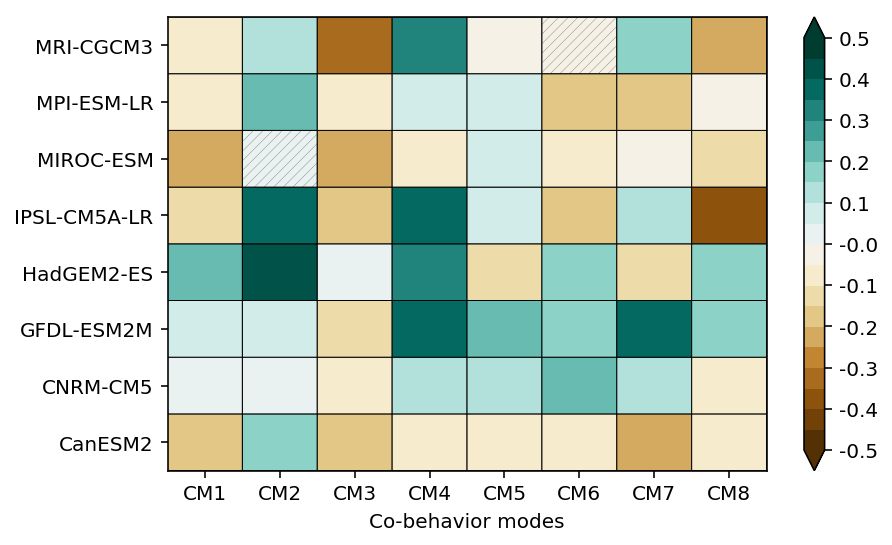

In [5]:
#reshape data to 8*8*2 variables and dataframe each variable
modcorrsout = np.array(modcorrs).reshape(8,8,2)

#extract correlation and pvalue dataframes
DF_correlation = pd.DataFrame(modcorrsout[:,:,0])
DF_pvalue = pd.DataFrame(modcorrsout[:,:,1])

#print(DF_correlation)
#make a dictionary to force plot in a strict order...'sorted' failed to do that huh!
headers_x = {1:'CM1',2:'CM2',3:'CM3',4:'CM4',5:'CM5',6:'CM6',7:'CM7',8:'CM8'}

xlist =[]
for key, value in headers_x.items():
    xlist.append(value)
    
headers_y = {1: 'CanESM2', 2: 'CNRM-CM5', 3: 'GFDL-ESM2M', 4: 'HadGEM2-ES', 
             5: 'IPSL-CM5A-LR', 6: 'MIROC-ESM', 7:'MPI-ESM-LR', 8: 'MRI-CGCM3'}

ylist =[]
for key, value in headers_y.items():
    ylist.append(value)


#now lets make the plot :-) and center the ticks on axis to label them
fig, ax = plt.subplots(figsize=(8,5))
fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

mmin = -0.5
mmax = 0.5

bounds = np.linspace(-0.5, 0.5, 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

heatmap = ax.pcolor(DF_correlation,edgecolors='k',norm=norm,cmap = 'BrBG',vmin=mmin,vmax=mmax, linewidth=0.5) #grayify_cmap('BrBG')
pval = np.ma.masked_where(DF_pvalue<0.05,DF_pvalue)
plt.pcolor(pval, hatch='/////',cmap = 'BrBG', linewidth=0.,alpha=-0.)
cbar = plt.colorbar(heatmap,ticks=np.arange(-0.5,0.51,0.1),format = '%.1f',extend='both')  #,ticks=np.arange(-0.4,0.5,0.1),extend='both'

# Loop over data dimensions and create text annotations
#data = np.array(DF_correlation)
#for y in range(data.shape[0]):
#    for x in range(data.shape[1]):
#        plt.text(x + 0.5, y + 0.5, '%.2f' % data[y, x],
#                 horizontalalignment='center',
#                 verticalalignment='center')
        
        
# Set ticks in center of cells
ax.set_xticks(np.arange(DF_correlation.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(DF_correlation.shape[0]) + 0.5, minor=False)

# Rotate the xlabels. Set both x and y labels to headers[0:]
ax.set_xticklabels(xlist[0:]) #,rotation=90
ax.set_yticklabels(ylist[0:])
ax.set_xlabel('Co-behavior modes')


#saving plot
plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_precip_heatmap_ntsig_v9.png',bbox_inches='tight', dpi = 600)
plt.show()

In [6]:
#plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_precip_heatmap_ntsig_v9.png',bbox_inches='tight', dpi = 600)

<Figure size 432x288 with 0 Axes>

In [6]:
#store variable to plot in trend heatmap
%store pval

Stored 'pval' (MaskedArray)


### P value < 0.05 tells that there is (monotonic)trend and if 𝜏 is +ve, increasing trend, and if 𝜏 is -ve, decreasing trend p value >0.05, no monotonic trend, away from monotonic trend.

In [16]:
bounds = np.linspace(-0.5, 0.5, 11)
print(bounds)

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]


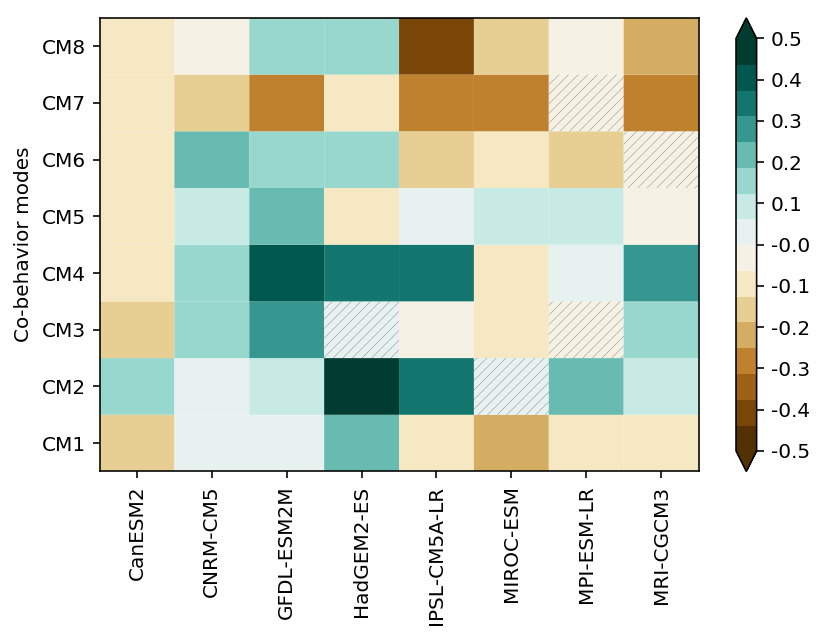

In [69]:
#reshape data to 8*8*2 variables and dataframe each variable
modcorrsout = np.array(modcorrs).reshape(8,8,2)

#extract correlation and pvalue dataframes
DF_correlation = pd.DataFrame(modcorrsout[:,:,0])
DF_pvalue = pd.DataFrame(modcorrsout[:,:,1])

#print(DF_correlation.T)
#make a dictionary to force plot in a strict order...'sorted' failed to do that huh!
headers_y = {1:'CM1',2:'CM2',3:'CM3',4:'CM4',5:'CM5',6:'CM6',7:'CM7',8:'CM8'}

ylist =[]
for key, value in headers_y.items():
    ylist.append(value)
    
headers_x = {1: 'CanESM2', 2: 'CNRM-CM5', 3: 'GFDL-ESM2M', 4: 'HadGEM2-ES', 
             5: 'IPSL-CM5A-LR', 6: 'MIROC-ESM', 7:'MPI-ESM-LR', 8: 'MRI-CGCM3'}

xlist =[]
for key, value in headers_x.items():
    xlist.append(value)


#now lets make the plot :-) and center the ticks on axis to label them
fig, ax = plt.subplots(figsize=(8,5))
fig.subplots_adjust(bottom=0.25,left=0.25) # make room for labels

mmin = -0.5
mmax = 0.5

bounds = np.linspace(-0.5, 0.5, 17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

heatmap = ax.pcolor(DF_correlation.T,norm=norm, edgecolors='k',cmap = 'BrBG',vmin=mmin,vmax=mmax, linewidth=0) #,norm=norm
pval = np.ma.masked_where(DF_pvalue.T<0.05,DF_pvalue.T)
plt.pcolor(pval, hatch='/////',cmap = 'BrBG', linewidth=0.,alpha=-0.)
cbar = plt.colorbar(heatmap,ticks=np.arange(-0.5,0.51,0.1),format ='%.1f',extend='both')  #,ticks=np.arange(-0.4,0.5,0.1),extend='both'

# Loop over data dimensions and create text annotations
#data = np.array(DF_correlation.T)
#for y in range(data.shape[0]):
#    for x in range(data.shape[1]):
#        plt.text(x + 0.5, y + 0.5, '%.3f' % data[y, x],
#                 horizontalalignment='center',
#                verticalalignment='center')

        
# Set ticks in center of cells
ax.set_xticks(np.arange(DF_correlation.T.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(DF_correlation.T.shape[0]) + 0.5, minor=False)

# Rotate the xlabels. Set both x and y labels to headers[0:]
ax.set_xticklabels(xlist[0:],rotation=90) #,rotation=90
ax.set_yticklabels(ylist[0:])
ax.set_ylabel('Co-behavior modes')

#saving plot
plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_precip_heatmap_ntsig_alt.png',bbox_inches='tight', dpi = 600)
plt.show()

(-0.5, 0.5)

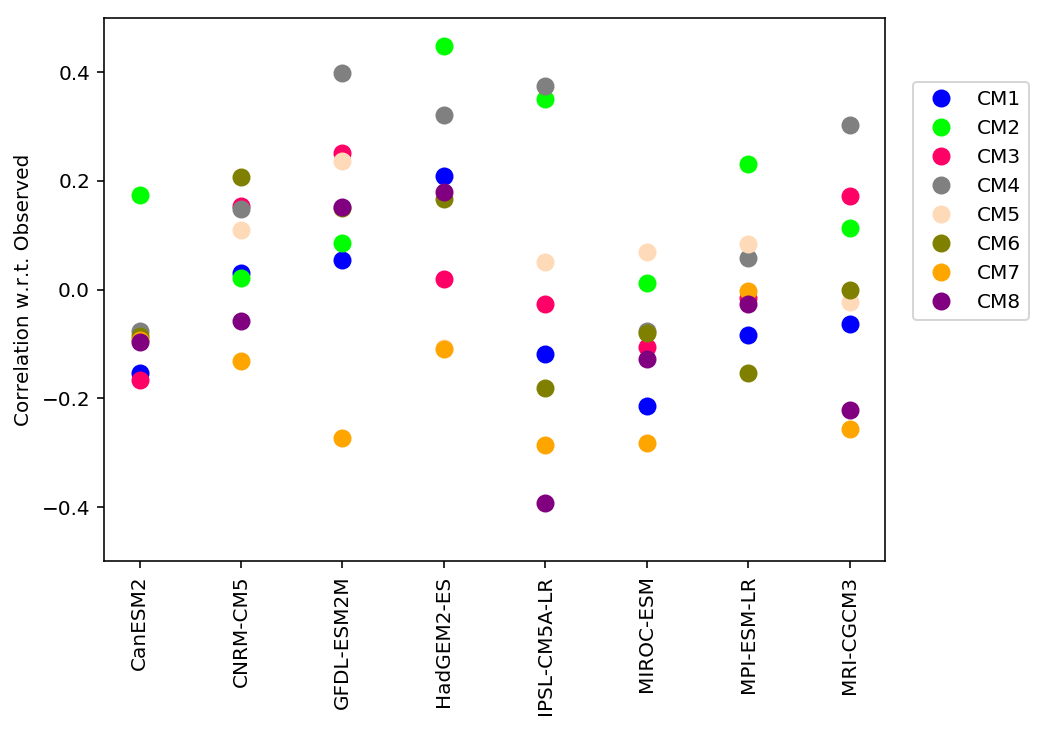

In [6]:
fig, ax = plt.subplots(figsize=(7,5))


#blue,lime,red,grey,peachpuff,olive,orange,purple
colors=["#0000FF", "#00FF00", "#FF0066",'#808080','#FFDAB9',
        '#808000','#FFA500','#800080']

for i in range(len(DF_correlation)):
    plt.plot(DF_correlation[i], 'go', ms=8,color=colors[i])
#plot(x+0.01*n,y)
    

# Set ticks in center of cells
ax.set_xticks(np.arange(DF_correlation.shape[1]), minor=False)
ax.set_xticklabels(xlist[0:],rotation=90)
ax.set_ylabel('Correlation w.r.t. Observed')
ax.legend(ylist[0:],loc='upper center', bbox_to_anchor=(1.11, 0.9), shadow=False, ncol=1)
ax.set_ylim([-0.5,0.5])
#alternate legend placement
#ax.legend(xlist[0:],loc='upper center', bbox_to_anchor=(0.5, -0.12), shadow=False, ncol=4)


#saving plot
plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_precip_dotplot_correlation_multicol_alt.png',bbox_inches='tight', dpi = 600)


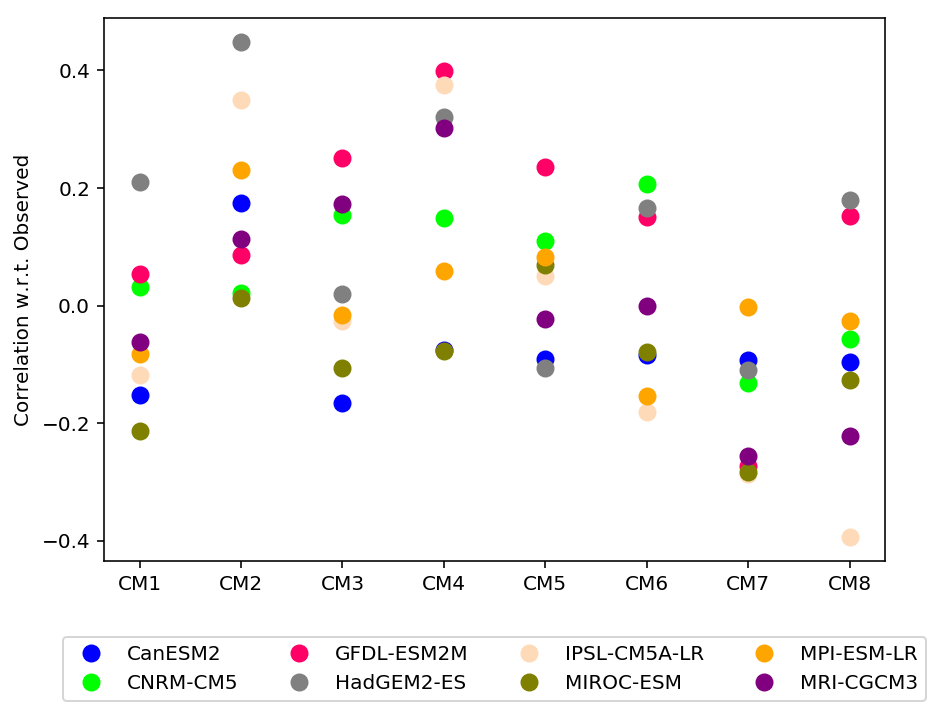

In [11]:
fig, ax = plt.subplots(figsize=(7,5))


#blue,lime,red,grey,peachpuff,olive,orange,purple
colors=["#0000FF", "#00FF00", "#FF0066",'#808080','#FFDAB9',
        '#808000','#FFA500','#800080']

for i in range(len(DF_correlation.T)):
    plt.plot(DF_correlation.T[i], 'go', ms=8,color=colors[i])

    

# Set ticks in center of cells
ax.set_xticks(np.arange(DF_correlation.shape[1]), minor=False)
ax.set_xticklabels(ylist[0:])
ax.set_ylabel('Correlation w.r.t. Observed')
#ax.legend(xlist[0:],loc='upper center', bbox_to_anchor=(1.16, 0.9), shadow=False, ncol=1)

#alternate legend placement
ax.legend(xlist[0:],loc='upper center', bbox_to_anchor=(0.5, -0.12), shadow=False, ncol=4)


#saving plot
plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_precip_dotplot_correlation_multicol.png',bbox_inches='tight', dpi = 600)



fig, ax = plt.subplots()
plt.plot(DF_correlation, 'go', ms=8)
# Set ticks in center of cells
ax.set_xticks(np.arange(DF_correlation.shape[1]), minor=False)
ax.set_xticklabels(xlist[0:],rotation=90)
ax.set_ylabel('Correlation w.r.t. Observed')
ax.set_ylim([-0.5,0.5])

#saving plot
plt.savefig('/home/kwesi/terra/research/paper2/plots/gcm_dotplot_correlation.png',bbox_inches='tight', dpi = 600)


modcorrsout=np.array(modcorrs).reshape(8,8,2)
#dataframe = pd.DataFrame.from_records(modcorrsout)

ax = plt.gca;
fig = plt.figure()
ax=plt.pcolor(modcorrsout[:,:,0],edgecolors='k',cmap = 'BrBG', linewidth=0)
pval = np.ma.masked_where(modcorrsout[:,:,1]<0.05,modcorrsout[:,:,1])
plt.pcolor(pval, hatch='////',cmap = 'BrBG', linewidth=2)
plt.colorbar(ticks=np.arange(-2,2,0.1))

#plt.savefig('/Volumes/Maxtor/paper2/data/precip/gcm_heatmap.png', dpi = 300)
plt.show()

#sanity check§

# read data NCs
chirps = Dataset('/Volumes/Maxtor/paper2/data/precip/pr_Amon_CHIRPS_rcp85_r1i1p1_198001-201312.3_mm.mask.nc','r')
mod = Dataset('/Volumes/Maxtor/paper2/data/precip/pr_Amon_HadGEM2-ES_rcp85_r1i1p1_198001-201312.3_mm.mask.nc','r')

#extract coordinates
time = chirps.variables['time'][:]
lons = chirps.variables['lon'][:]
lats = chirps.variables['lat'][:]
chz = chirps.variables['anom'][:]
crl = mod.variables['anom'][:]
chirps.variables['anom'],mod.variables['anom']

tau,p_value = scipy.stats.kendalltau(chz,crl,nan_policy='propagate')

print(tau,p_value)




#each column represents a model
print(DF_correlation)#;print(DF_pvalue)
plt.pcolor(DF_correlation,cmap = 'BrBG')

In [97]:
#for i in datamod:
#    for j in num:
#        print(anom_path + 'pr_Amon_CHIRPS_rcp85_r1i1p1_198001-201312.' + num[j] + '_mm.mask.nc',
#                 anom_path + 'pr_Amon_' + datamod[i] + '_rcp85_r1i1p1_198001-201312.' + num[j] + '_mm.mask.nc')